# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [3]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import plotly.graph_objects as go
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Life expectancy at 65 for countries in data set')

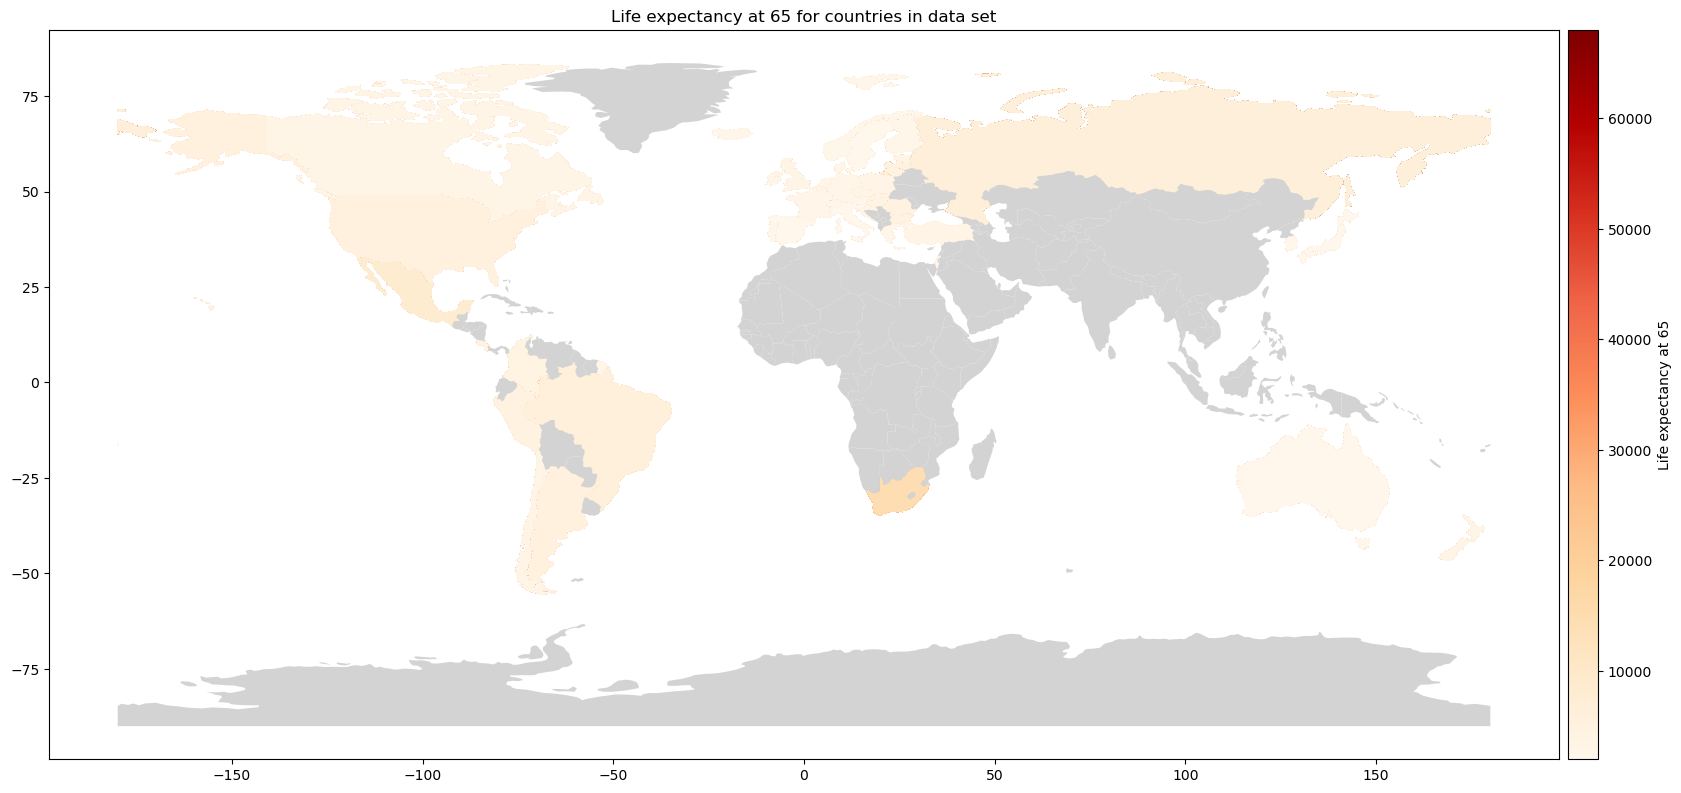

In [8]:
# making overview map for countries in data set
mapdata = pd.read_csv('yrlifelost.csv')
drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME','Flag Codes']
mapdata.drop(drop, axis=1, inplace=True)

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world_mapdata = df_world.merge(mapdata, how="left", left_on=['iso_a3'], right_on=['LOCATION'])

fig, ax = plt.subplots(1, 1, figsize=(20, 16))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad="0.5%")
df_world_mapdata.plot(column="Value", ax=ax, cax=cax, cmap='OrRd',legend=True, legend_kwds={"label": "Life expectancy at 65"}, missing_kwds={'color':'lightgrey'})
ax.set_title("Life expectancy at 65 for countries in data set")



# Read and clean data

In [2]:
# importing data
alcohol = pd.read_csv('alcohol.csv')
life_exp_65 = pd.read_csv('lifeexp65.csv')
overobese = pd.read_csv('overobese.csv')
smokers = pd.read_csv('smokers.csv')
social_support = pd.read_csv('socsupport.csv')

In [20]:
# clean alcohol data
drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
alcohol.drop(drop, axis=1, inplace=True)

alcohol.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'alcohol_sale'}, inplace=True)


# figure (alcohol)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='alcohol_sale', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(alcohol),
    country = widgets.Dropdown(description='country', 
                                    options=alcohol.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN'…

In [32]:
alcohol_wide = pd.pivot(alcohol,index='country',columns='year',values='alcohol_sale')

col_dict = {}
for i in range(1960,2022):
    col_dict[str(i)] = f'alc{i}'

col_dict = {str(i) : f'alc{i}' for i in range(1960,2022)}

alcohol_wide.rename(columns =col_dict, inplace=True)

#drop_list=[*range(1960,2000)]
#drop_list.append(2021)

#alcohol_wide.drop(drop_list, axis=1, inplace=True)



In [3]:
# clean life_exp_65 data
drop = ['INDICATOR','MEASURE','FREQUENCY','Flag Codes']
life_exp_65.drop(drop, axis=1, inplace=True)

life_exp_65.rename(columns={'LOCATION':'country', 'SUBJECT':'sex','TIME':'year', 'Value':'exp_years'}, inplace=True)

life_exp_65_wide = pd.pivot_table(life_exp_65,index='country',columns='year',values='exp_years')



In [4]:
# figure (life_exp_65)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='exp_years', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(life_exp_65_wide),
    country = widgets.Dropdown(description='country', 
                                    options=life_exp_65_wide.country.unique(), 
                                    value='AUS')
);

#life_exp_65_long = pd.melt(life_exp_65_wide, id_vars='country',value_vars='year')

AttributeError: 'DataFrame' object has no attribute 'country'

In [ ]:
# clean overobese data
drop = ['INDICATOR','MEASURE','FREQUENCY','Flag Codes']
overobese.drop(drop, axis=1, inplace=True)

overobese.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'share_obese'}, inplace=True)

# lav funktion som vælger enten self-reported eller den anden

# figure (overobese)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='share_obese', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(overobese),
    country = widgets.Dropdown(description='country', 
                                    options=overobese.country.unique(), 
                                    value='AUS')
);

In [3]:
# clean smokers data
I = smokers.SUBJECT.str.contains('WOMEN')
I |= smokers.SUBJECT.str.contains('MEN')
smokers.loc[I,:]
smokers = smokers.loc[I == False]

drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
smokers.drop(drop, axis=1, inplace=True)

smokers.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'smoking'}, inplace=True)


# figure (smokers)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='smoking', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(smokers),
    country = widgets.Dropdown(description='country', 
                                    options=smokers.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN'…

In [5]:
# clean social_support data
I = social_support.SUBJECT.str.contains('TOT')
social_support.loc[I,:]
social_support = social_support.loc[I == True]

drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
social_support.drop(drop, axis=1, inplace=True)

social_support.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'share_support'}, inplace=True)


# figure (social_support)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='share_support', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(social_support),
    country = widgets.Dropdown(description='country', 
                                    options=social_support.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN'…

In [ ]:
# overview
alcohol_wide
#life_exp_65_wide
#overobese_wide
#smokers_wide
#social_support_wide

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

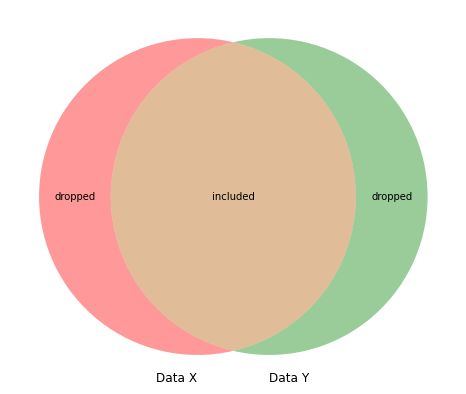

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.